<a href="https://colab.research.google.com/github/araujorobert/Time-series-course/blob/main/Tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts      # Herramientas estadisticas
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sb
sb.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importando datos

In [3]:
data = pd.read_csv('Index2018.csv')
# Transformamos la columna "date" de string a objeto tipo fecha
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
# Establecemos la fecha como indice del dataframe
data = data.set_index('date')
# Aplicamos la opcion business day para no tener problemas con los fines de semana
data = data.asfreq('b')
# cambiamos los valores nulos usando la siguiente observacion
data = data.fillna(method='ffill')
data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
# Nos quedamos con la columna ftse
data['market_value'] = data.ftse

# Dropeamos todas las demas
data = data.drop(['spx','dax','ftse','nikkei'], axis=1)
data.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


In [6]:
# dividimos en conjunto de entrenamiento y validación
size = int(len(data)*0.8)
df, df_test = data[size:], data[:size]

# Comprobamos las magnitudes
# Combrobamos las longitudes
print('La longitud del conjunto de entrenamiento es',round(len(df)/len(data),3))
print('La longitud del conjunto de prueba es',round(len(df_test)/len(data),3))

La longitud del conjunto de entrenamiento es 0.2
La longitud del conjunto de prueba es 0.8


## DF-Test (para comprobar si la serie es estacionaria)

In [7]:
sts.adfuller(df['market_value'])

(-1.644785714780123,
 0.4597612273360785,
 4,
 1251,
 {'1%': -3.4355880246374304,
  '10%': -2.568001531098063,
  '5%': -2.8638531175675896},
 13359.94152868575)

Vemos que el p-valor es muy alto, por lo que no podemos rechazar la hipotesis nula. La hipotesis nula nos dice que la serie no es estacionaria.

Cuando trabajamos con precios en general las series no son estacionarias. Para volverlas estacionarias calculamos los retornos, estos son porcentajes de cambio entre precios consecutivos. Adelante veremos que los retornos si son estacionarios y nos permiten aprovechar las ventajas de las series estacionarias.

In [8]:
# Calculamos los retornos
df['returns'] = df['market_value'].pct_change(1).mul(100)
df = df.iloc[1:] # Eliminamos la primera observacion porque contendra una NaN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
df.head()

,market_value,returns
date,,
2013-04-09,6313.200000,0.577670
2013-04-10,6387.370000,1.174840
2013-04-11,6416.140000,0.450420
2013-04-12,6384.390000,-0.494846
2013-04-15,6343.597833,-0.638936


In [10]:
# Volvemos a aplicar el DF test
sts.adfuller(df['returns'])

(-19.144530699208055,
 0.0,
 3,
 1251,
 {'1%': -3.4355880246374304,
  '10%': -2.568001531098063,
  '5%': -2.8638531175675896},
 3088.6645857988356)

El contraste fallo a favor de H1 que nos dice que la serie es estacionaria.

## ACF Y PACF

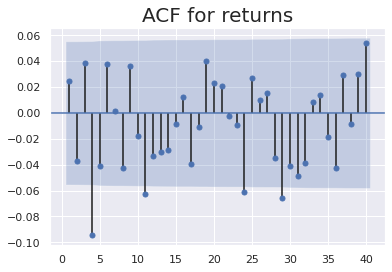

In [12]:
# Calculamos la funcion de auto-correlacion
sgt.plot_acf(df['returns'], zero=False, lags=40)
plt.title('ACF for returns', size=20)
plt.show()

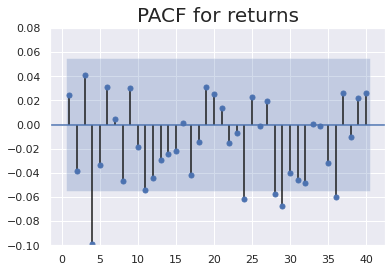

In [18]:
# Calculamos la función de auto correlacion parcial
sgt.plot_pacf(df['returns'], zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title('PACF for returns', size=20)
plt.ylim(-0.1,0.08)
plt.show()

## Modelos AR(p)

In [20]:
# AR1
model_ar = ARMA(df.returns, order=(1,0))
results_ar = model_ar.fit()
print(results_ar.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 1255
Model:                     ARMA(1, 0)   Log Likelihood               -1572.720
Method:                       css-mle   S.D. of innovations              0.847
Date:                Tue, 05 Apr 2022   AIC                           3151.440
Time:                        04:30:51   BIC                           3166.845
Sample:                    04-09-2013   HQIC                          3157.230
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0196      0.025      0.799      0.424      -0.028       0.068
ar.L1.returns     0.0245      0.028      0.868      0.385      -0.031       0.080
                                    Root

Los p-valores de los parametros del AR1 son mayores al nivel de significación, por lo tanto este modelo no es un buen predictor.

In [22]:
# AR2
model_ar2 = ARMA(df.returns, order=(2,0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 1255
Model:                     ARMA(2, 0)   Log Likelihood               -1571.809
Method:                       css-mle   S.D. of innovations              0.847
Date:                Tue, 05 Apr 2022   AIC                           3151.619
Time:                        04:32:56   BIC                           3172.158
Sample:                    04-09-2013   HQIC                          3159.339
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0195      0.024      0.827      0.408      -0.027       0.066
ar.L1.returns     0.0254      0.028      0.901      0.368      -0.030       0.081
ar.L2.returns    -0.0381      0.028     

Los p-valores de los parametros del AR2 son mayores al nivel de significación, por lo tanto este modelo no es un buen predictor.

In [23]:
# AR3
model_ar3 = ARMA(df.returns, order=(3,0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 1255
Model:                     ARMA(3, 0)   Log Likelihood               -1570.776
Method:                       css-mle   S.D. of innovations              0.846
Date:                Tue, 05 Apr 2022   AIC                           3151.553
Time:                        04:33:37   BIC                           3177.227
Sample:                    04-09-2013   HQIC                          3161.203
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0196      0.025      0.798      0.425      -0.029       0.068
ar.L1.returns     0.0270      0.028      0.956      0.339      -0.028       0.082
ar.L2.returns    -0.0391      0.028     

In [24]:
# AR4
model_ar4 = ARMA(df.returns, order=(4,0))
results_ar4 = model_ar4.fit()
print(results_ar4.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 1255
Model:                     ARMA(4, 0)   Log Likelihood               -1564.656
Method:                       css-mle   S.D. of innovations              0.842
Date:                Tue, 05 Apr 2022   AIC                           3141.311
Time:                        04:34:27   BIC                           3172.121
Sample:                    04-09-2013   HQIC                          3152.891
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0195      0.022      0.877      0.380      -0.024       0.063
ar.L1.returns     0.0310      0.028      1.104      0.270      -0.024       0.086
ar.L2.returns    -0.0428      0.028     

Vemos que en este caso, el ultimo p-valor si es significativo, por lo cual este modelo es mejor que los anteriores, sin embargo, como los p-valores de los demas parametros son mayores a 0.05 no podemos esperar que el modelo sea excelente.

In [25]:
# AR5
model_ar5 = ARMA(df.returns, order=(5,0))
results_ar5 = model_ar5.fit()
print(results_ar5.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 1255
Model:                     ARMA(5, 0)   Log Likelihood               -1563.958
Method:                       css-mle   S.D. of innovations              0.841
Date:                Tue, 05 Apr 2022   AIC                           3141.916
Time:                        04:36:06   BIC                           3177.860
Sample:                    04-09-2013   HQIC                          3155.426
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0195      0.022      0.907      0.365      -0.023       0.062
ar.L1.returns     0.0277      0.028      0.983      0.326      -0.028       0.083
ar.L2.returns    -0.0413      0.028     

Vemos que con el AR5 la situación empeora, ya que el ultimo p-valor vuelve a ser mayor que 0.05. por lo que concluimos que el modelo mas apropiado es el AR4.

## Análisis de Residuos

In [26]:
# Calculamos los residuos del modelo 7
df['res_returns'] = results_ar.resid

# Los residuos deben ser semejantes a ruido blanco, es decir, no deben tener correlación, o en otras palabras, deben ser estaiconarios.
# Para esto aplicamos el test de DF
sts.adfuller(df.res_returns)

(-19.21000488766195,
 0.0,
 3,
 1251,
 {'1%': -3.4355880246374304,
  '10%': -2.568001531098063,
  '5%': -2.8638531175675896},
 3088.8391289312867)

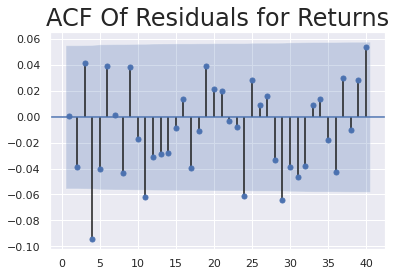

In [27]:
# El p-valor es cero, por lo tanto rechazamos la hipotesis nula que nos dice que los resoduos no son estacionarios.
# Para corroborar esto hacemos la grafica de correlacion
sgt.plot_acf(df.res_returns, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

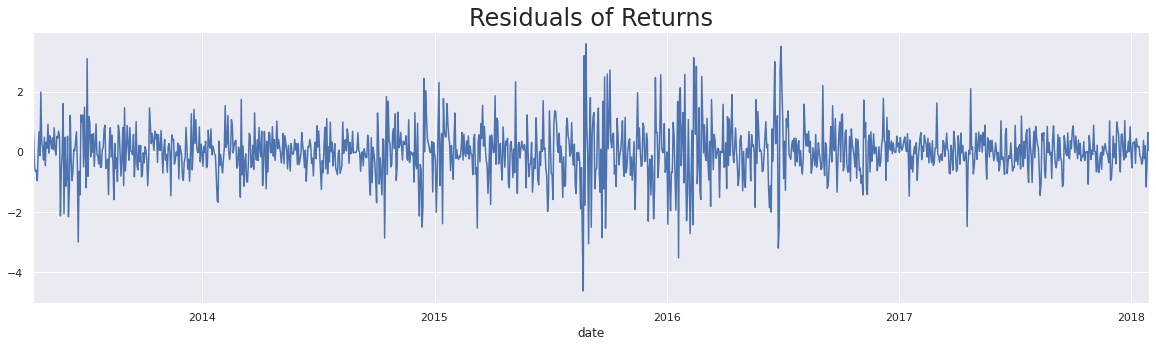

In [28]:
# Por ultimo ploteamos los residuos
df.res_returns[1:].plot(figsize=(20,5))
plt.title("Residuals of Returns",size=24)
plt.show()

In [29]:
# Repitiendo todo lo anterior para el AR4

# Calculamos los residuos del modelo 7
df['res_returns4'] = results_ar4.resid

# Los residuos deben ser semejantes a ruido blanco, es decir, no deben tener correlación, o en otras palabras, deben ser estaiconarios.
# Para esto aplicamos el test de DF
sts.adfuller(df.res_returns4)

(-35.505463635968134,
 0.0,
 0,
 1254,
 {'1%': -3.4355754676859886,
  '10%': -2.5679985805677017,
  '5%': -2.8638475772391665},
 3082.6561392773983)

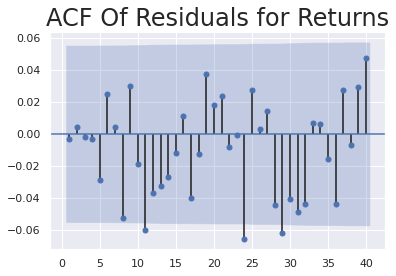

In [30]:
# El p-valor es cero, por lo tanto rechazamos la hipotesis nula que nos dice que los resoduos no son estacionarios.
# Para corroborar esto hacemos la grafica de correlacion
sgt.plot_acf(df.res_returns4, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

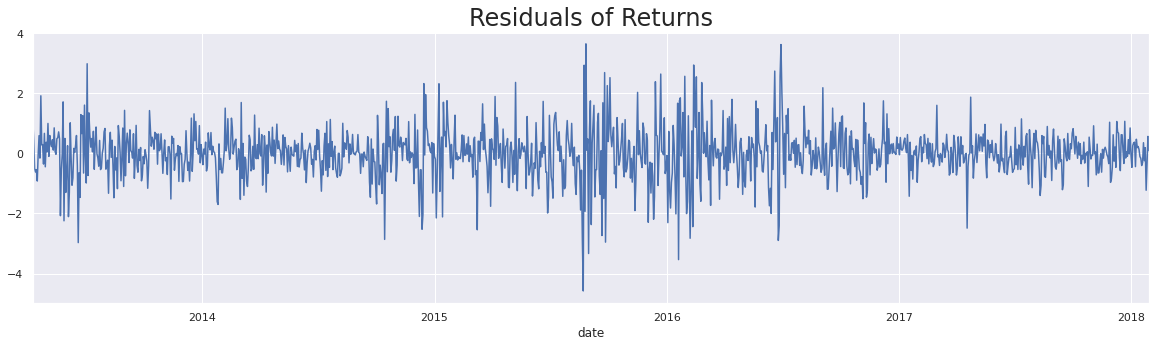

In [31]:
# Por ultimo ploteamos los residuos
df.res_returns4[1:].plot(figsize=(20,5))
plt.title("Residuals of Returns",size=24)
plt.show()